In [ ]:
# todo: If the AOI spans multiple tiles, we will need to merge (mosaic) them into a single image.

In [1]:
# Imports
import pystac_client
import planetary_computer
from pystac.extensions.eo import EOExtension as eo
import rasterio
import geopandas as gpd
from rasterio import windows, features, warp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import odc.stac
from tqdm.auto import tqdm
import rioxarray

In [2]:
# Define the path to the GeoJSON file
geojson_path = "aoi.geojson"

# Set the cloud cover threshold (percentage)
CLOUD_COVER = 20

# Specify the tile identifier
TILE = '23LLF'

# Define the output file name for the resulting image (8 bands)
output_file = "aoi_output_8b.tif"

In [3]:
# Configuration for accessing the Planetary Computer catalog

# Open the STAC (SpatioTemporal Asset Catalog) client for the Planetary Computer API
# The modifier `planetary_computer.sign_inplace` signs the request for authentication
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",  # URL of the Planetary Computer STAC API
    modifier=planetary_computer.sign_inplace,  # Apply authentication for API access
)


In [4]:
# Load the Area of Interest (AOI) from a GeoJSON file (GCS)
def load_aoi_from_geojson(geojson_path):
    # Read the GeoJSON file into a GeoDataFrame using GeoPandas
    gdf = gpd.read_file(geojson_path)
    
    # Assume that the first geometry in the GeoDataFrame represents the AOI
    aoi = gdf.geometry[0]
    
    # Convert the AOI geometry to GeoJSON format and return it
    return aoi.__geo_interface__

# Load the AOI using the function defined above
area_of_interest = load_aoi_from_geojson(geojson_path)


In [5]:
import json

# Load the GeoJSON file
with open(geojson_path, 'r') as f:
    area_of_interest = json.load(f)

# Extract the geometry of the first feature
geometry = area_of_interest["features"][0]["geometry"]
coords = geometry["coordinates"]

# Check the geometry type and adjust the coordinates accordingly
if geometry["type"] == "Polygon":
    # If the geometry is a Polygon, use the first ring (usually the exterior)
    coords = coords[0]
elif geometry["type"] == "MultiPolygon":
    # If the geometry is a MultiPolygon, use the first polygon's first ring
    coords = coords[0][0]

# Calculate the bounding box by finding the min and max x and y values
minx = min(coord[0] for coord in coords)
miny = min(coord[1] for coord in coords)
maxx = max(coord[0] for coord in coords)
maxy = max(coord[1] for coord in coords)

# Format the bounding box as a tuple (minx, miny, maxx, maxy)
bbox = (minx, miny, maxx, maxy)

# Print the resulting bounding box
print("bbox:", bbox)


bbox: (-46.272926124399774, -13.307635642318433, -46.147119041828304, -13.200486694152026)


In [6]:
# Function to search for the least cloudy Sentinel-2 image within a specified time range and area of interest
def search_least_cloudy(catalog, time_range, aoi, CLOUD_COVER, TILE):
    # Extract the geometry of the Area of Interest (AOI)
    geometry = aoi["features"][0]["geometry"]
    
    # Perform the search on the catalog
    search = catalog.search(
        collections=["sentinel-2-l2a"],  # Search within the Sentinel-2 L2A collection
        intersects=geometry,  # Use the geometry of the AOI to define the search area
        datetime=time_range,  # Search within the specified time range
        query={  # Filter the search results based on cloud cover and tile ID
            "eo:cloud_cover": {"lt": CLOUD_COVER},  # Cloud cover must be less than the specified threshold
            "s2:mgrs_tile": {"eq": TILE}  # Filter by the specified tile
        },
    )
    
    # Retrieve the items (images) that match the search criteria
    items = search.item_collection()
    print(f"Returned {len(items)} items for the period {time_range}")
    
    # Check if no items were found
    if len(items) == 0:
        raise ValueError(f"No items found in the period {time_range}.")
    
    # Select the item with the least cloud cover
    least_cloudy_item = min(items, key=lambda item: item.properties["eo:cloud_cover"])
    
    # Return the item with the least cloud cover
    return least_cloudy_item

# Function to process the raster image (resize and crop based on AOI)
def process_raster(asset_href, aoi, target_width=800):
    # Open the raster file using rasterio
    with rasterio.open(asset_href) as ds:
        # Get the bounds of the AOI
        aoi_bounds = features.bounds(aoi)
        
        # Transform the AOI bounds to the coordinate reference system of the raster
        warped_bounds = warp.transform_bounds("epsg:4326", ds.crs, *aoi_bounds)
        
        # Create a window for reading the raster data within the AOI bounds
        aoi_window = windows.from_bounds(*warped_bounds, transform=ds.transform)
        
        # Read the raster data within the AOI window
        band_data = ds.read(window=aoi_window)
    
    # Convert the band data to an image using PIL
    img = Image.fromarray(np.transpose(band_data, axes=[1, 2, 0]))
    
    # Calculate the aspect ratio of the image
    aspect_ratio = img.width / img.height
    
    # Calculate the target height based on the target width to maintain the aspect ratio
    target_height = int(target_width / aspect_ratio)
    
    # Resize the image to the target dimensions
    return img.resize((target_width, target_height), Image.Resampling.BILINEAR)


In [7]:
# Search for the least cloudy images in two different time ranges
least_cloudy_item_1 = search_least_cloudy(catalog, "2024-03-01/2024-04-30", area_of_interest, CLOUD_COVER, TILE)
least_cloudy_item_2 = search_least_cloudy(catalog, "2024-10-01/2024-12-01", area_of_interest, CLOUD_COVER, TILE)

# Get the URLs for the visual assets (image URLs) of the least cloudy images
asset_href_1 = least_cloudy_item_1.assets["visual"].href  # URL of the visual asset for the first image
asset_href_2 = least_cloudy_item_2.assets["visual"].href  # URL of the visual asset for the second image


Returned 3 items for the period 2024-03-01/2024-04-30
Returned 2 items for the period 2024-10-01/2024-12-01


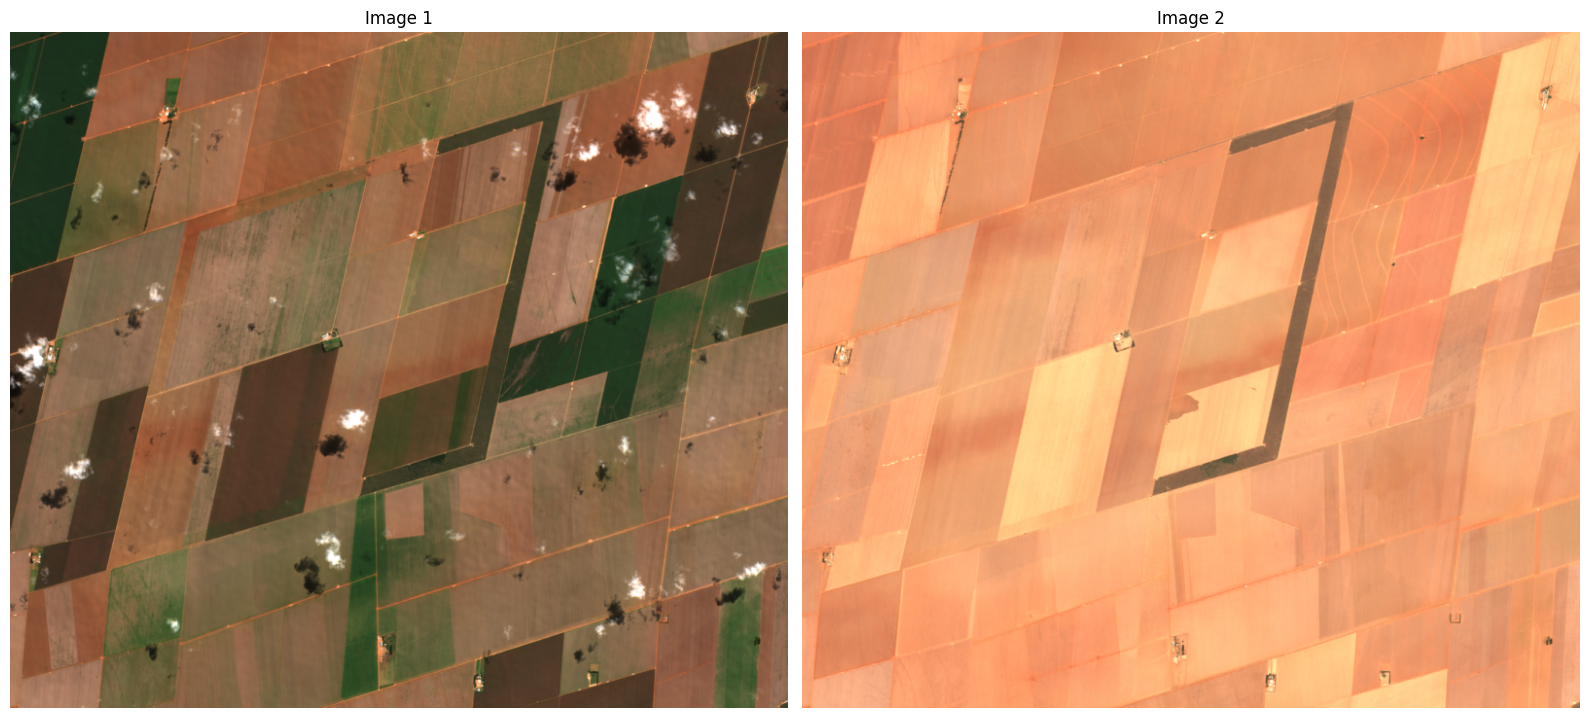

In [8]:
# Process and display the two images side by side

# Process the raster data of the least cloudy images
img1 = process_raster(asset_href_1, area_of_interest)
img2 = process_raster(asset_href_2, area_of_interest)

# Create a figure with two subplots for displaying the images side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Display the first image in the left subplot
axes[0].imshow(img1)
axes[0].set_title("Image 1")  # Title for the first image
axes[0].axis("off")  # Turn off the axis for a cleaner display

# Display the second image in the right subplot
axes[1].imshow(img2)
axes[1].set_title("Image 2")  # Title for the second image
axes[1].axis("off")  # Turn off the axis for a cleaner display

# Adjust layout to avoid overlapping and ensure proper spacing
plt.tight_layout()

# Show the plot with the images
plt.show()


In [9]:
# Load data using odc.stac and save it as a GeoTIFF

# Load the selected bands (B04, B03, B02, B08) from the least cloudy images using odc.stac
# The data is resampled with bilinear interpolation, and the bounding box (bbox) is used for the area of interest
data = odc.stac.load(
    [least_cloudy_item_1, least_cloudy_item_2],  # List of items to load data from
    bands=["B04", "B03", "B02", "B08"],  # Selected bands (Red, Green, Blue, and Near Infrared)
    dtype="uint16",  # Data type for the bands (16-bit unsigned integer)
    resampling="bilinear",  # Resampling method for raster data
    bbox=bbox,  # Bounding box for the area of interest
    progress=tqdm  # Use tqdm for showing progress
)

# Merge the data into a single array and restructure it
print("Merging data")
# Convert the data to a 3D array where the dimensions are 'time', 'band', and 'x/y' coordinates
data = data.to_array(dim="band").stack(bands=("time", "band")).drop_vars("band").transpose('bands', 'y', 'x')

# Write the data to a GeoTIFF file
print("Writing output")

# Use the timestamp from the first image as the valid datetime for the GeoTIFF
timestamp = least_cloudy_item_1.datetime  # Setting a valid timestamp

# Save the data to a GeoTIFF file with compression and tiling options
data.rio.to_raster(
    output_file,  # Output file path
    driver="GTiff",  # GeoTIFF format
    compress="deflate",  # Compression method
    dtype="uint16",  # Data type for the raster
    tiled=True,  # Enable tiling for the raster
    blockxsize=256,  # Block size for x dimension
    blockysize=256,  # Block size for y dimension
    tags={"TIFFTAG_DATETIME": timestamp.strftime("%Y:%m:%d %H:%M:%S")}  # Add datetime as a tag in the TIFF file
)

# Print the location where the file was saved
print(f"File saved as {output_file}")


  0%|          | 0/8 [00:00<?, ?it/s]

Merging data
Writing output
File saved as aoi_output_8b.tif


In [ ]:
# Optionally - Run the inference

# Path to the pre-trained model checkpoint
model_path = "pre-trained-model.ckpt"

# Path to save the inference output as a GeoTIFF file
inference_output = "inference-output.tif"


In [ ]:
# ---Perform inference ---

# Print a message indicating the inference process is starting
print("\n🧠 Performing inference on the image...\n")

# Run the inference using the 'ftw' command-line tool
# This command takes the output GeoTIFF file, loads the pre-trained model, and saves the inference results to a new file.
# - {output_file}: The input image for inference
# - {model_path}: The path to the pre-trained model checkpoint
# - {inference_output}: The path to save the inference result
# - --gpu 0: Use GPU with ID 0 for inference (assuming GPU is available)
# - --overwrite: Overwrite the output file if it already exists

!ftw inference run {output_file} --model {model_path} --out {inference_output} --gpu 0 --overwrite


In [ ]:
# Print a message indicating the polygon extraction process is starting
print("\n📐 Extracting polygons...\n")

# Run the polygonization process using the 'ftw' command-line tool
# This command converts the inference result into polygons, which is useful for vectorizing raster data.
# - {inference_output}: The output file from the inference process (GeoTIFF)
# - --simplify 0: Ensures that no simplification is applied to the polygons, preserving their original shape

!ftw inference polygonize {inference_output} --simplify 0

# Print a message indicating the process has finished
print('Finished!')
